In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import json
from matplotlib import pyplot as py
%matplotlib inline
import matplotlib
matplotlib.rcParams["figure.figsize"] = (20,10)
from sklearn.model_selection import GridSearchCV


In [31]:
df = pd.read_csv("melhousedata.csv")

In [32]:
df.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,1.0,202.0,NaN,NaN,Yarra,-37.7996,144.9984,Northern Metropolitan,4019.0
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra,-37.8079,144.9934,Northern Metropolitan,4019.0
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,2.0,0.0,134.0,150.0,1900.0,Yarra,-37.8093,144.9944,Northern Metropolitan,4019.0
3,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,4/03/2017,2.5,3067.0,...,2.0,1.0,94.0,NaN,NaN,Yarra,-37.7969,144.9969,Northern Metropolitan,4019.0
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,...,1.0,2.0,120.0,142.0,2014.0,Yarra,-37.8072,144.9941,Northern Metropolitan,4019.0


In [33]:
df.shape

(13580, 21)

In [34]:
df.columns

Index(['Suburb', 'Address', 'Rooms', 'Type', 'Price', 'Method', 'SellerG',
       'Date', 'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car',
       'Landsize', 'BuildingArea', 'YearBuilt', 'CouncilArea', 'Lattitude',
       'Longtitude', 'Regionname', 'Propertycount'],
      dtype='object')

In [35]:
#Dropping columns that are not needed for analysis
df1 = df.drop(['Bedroom2','Address', 'Method', 'SellerG', 'Postcode', 'CouncilArea', 'Lattitude', 'Longtitude', 'Propertycount'], axis='columns')
df1.head()

,Suburb,Rooms,Type,Price,Date,Distance,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Regionname
0,Abbotsford,2,h,1480000.0,3/12/2016,2.5,1.0,1.0,202.0,NaN,NaN,Northern Metropolitan
1,Abbotsford,2,h,1035000.0,4/02/2016,2.5,1.0,0.0,156.0,79.0,1900.0,Northern Metropolitan
2,Abbotsford,3,h,1465000.0,4/03/2017,2.5,2.0,0.0,134.0,150.0,1900.0,Northern Metropolitan
3,Abbotsford,3,h,850000.0,4/03/2017,2.5,2.0,1.0,94.0,NaN,NaN,Northern Metropolitan
4,Abbotsford,4,h,1600000.0,4/06/2016,2.5,1.0,2.0,120.0,142.0,2014.0,Northern Metropolitan


In [7]:
df1.columns

Index(['Suburb', 'Rooms', 'Type', 'Price', 'Date', 'Distance', 'Bathroom',
       'Car', 'Landsize', 'BuildingArea', 'YearBuilt', 'Regionname'],
      dtype='object')

In [8]:
df1.isnull().sum()

Suburb             0
Rooms              0
Type               0
Price              0
Date               0
Distance           0
Bathroom           0
Car               62
Landsize           0
BuildingArea    6450
YearBuilt       5375
Regionname         0
dtype: int64

In [9]:
# Removing 'building_area' since we already have 'landsize',  
# and nearly 50% of its values are missing.
df2 = df1.drop(['BuildingArea'], axis='columns') 
df2.columns

Index(['Suburb', 'Rooms', 'Type', 'Price', 'Date', 'Distance', 'Bathroom',
       'Car', 'Landsize', 'YearBuilt', 'Regionname'],
      dtype='object')

In [10]:
df3 = df2.drop(['YearBuilt'], axis='columns') 

In [11]:
# Removing 'cars' column since it has only 62 missing values,  
# which is a small portion of the dataset.
df4 = df3.dropna() 
df4.isnull().sum()

Suburb        0
Rooms         0
Type          0
Price         0
Date          0
Distance      0
Bathroom      0
Car           0
Landsize      0
Regionname    0
dtype: int64

In [12]:
# The dataset contains only two years of data,  
# which is not a significant enough gap to impact house prices.  
# Therefore, removing the 'year' column.

df4['Date'] = pd.to_datetime(df4['Date'])

start_date = df4['Date'].min()
end_date = df4['Date'].max()

print("Start Date:", start_date)
print("End Date:", end_date)

df5 = df4.drop(['Date'], axis='columns')

Start Date: 2016-01-28 00:00:00
End Date: 2017-12-08 00:00:00


<ipython-input-12-d8db24e7a899>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4['Date'] = pd.to_datetime(df4['Date'])


In [13]:
#removing duplicated values

df5.drop_duplicates(inplace=True)
df5.duplicated().sum()


0

In [14]:
df5.Suburb = df5.Suburb.apply(lambda x: x.strip()) #remove white spaces from the value
suburbs = df5.groupby('Suburb')['Suburb'].agg('count').sort_values(ascending=False)
suburbs_less_then_10 = suburbs[suburbs <=10]
df5.Suburb = df5.Suburb.apply(lambda x: 'other' if x in suburbs_less_then_10 else x)

In [15]:
df5['Land_per_Room'] = df5.apply(lambda x: x['Landsize'] / x['Rooms'] if x['Landsize'] > 0 else None, axis=1)

In [16]:
# on the basis of describe funtion and boxplot, i removed the outlier. 
df7 = df5[
    ((df5['Type'] == 'h') & (df5['Land_per_Room'].between(50, 320) | (df5['Landsize'] == 0.0))) |
    ((df5['Type'] == 'u') & (df5['Land_per_Room'].between(40, 200) | (df5['Landsize'] == 0.0))) |
    ((df5['Type'] == 't') & (df5['Land_per_Room'].between(45, 130) | (df5['Landsize'] == 0.0)))
]

In [17]:
summary_stats = df7.groupby('Type')['Land_per_Room'].describe()
print(summary_stats)

       count        mean        std   min         25%    50%         75%  \
Type                                                                       
h     8577.0  161.086983  59.843317  50.0  114.250000  160.0  202.000000   
t      718.0   78.142781  20.282936  45.0   62.083333   75.5   92.333333   
u      760.0   87.577138  30.638348  40.0   65.000000   83.0  104.500000   

             max  
Type              
h     320.000000  
t     129.666667  
u     197.000000  


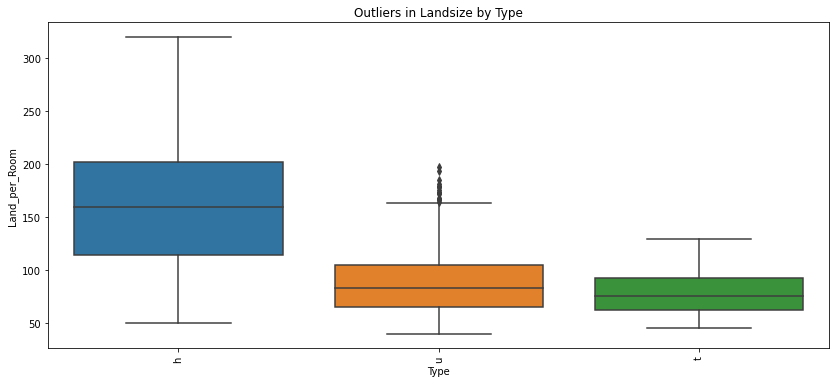

In [18]:
py.figure(figsize=(14, 6))
sns.boxplot(x='Type', y='Land_per_Room', data=df7)
py.xticks(rotation=90)  # Rotate x-axis labels for readability
py.title('Outliers in Landsize by Type')
py.show()

In [19]:
df7 = df7[~(df7['Landsize'] == 0)]
df7.shape

(10055, 10)

In [20]:
# Identified entries where the number of cars exceeds 10.  
# In Australia, typical houses have a maximum of 3 car spaces.  
# Removing these outliers.
df7 = df7[(df7['Car'] <= 4) | (df7['Car'] > df7['Rooms'])]
df7.shape

(10043, 10)

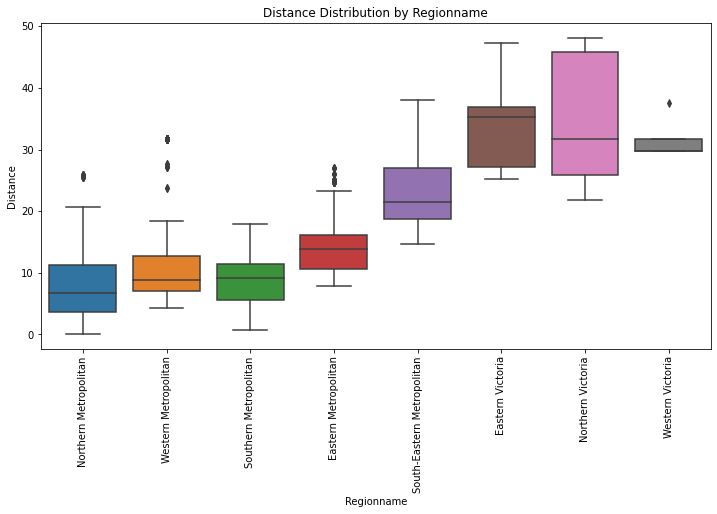

In [21]:
# The box plot indicates some outliers, such as distances of 30 km.  
# However, these likely represent houses located on the outskirts of the city.  
# Removing these outliers.
py.figure(figsize=(12, 6))
sns.boxplot(x='Regionname', y='Distance', data=df)
py.xticks(rotation=90)
py.title('Distance Distribution by Regionname')
py.show()

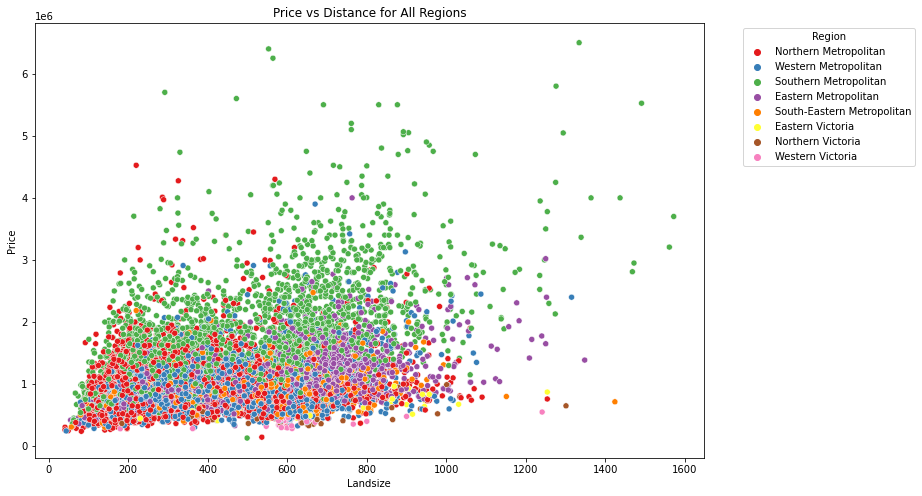

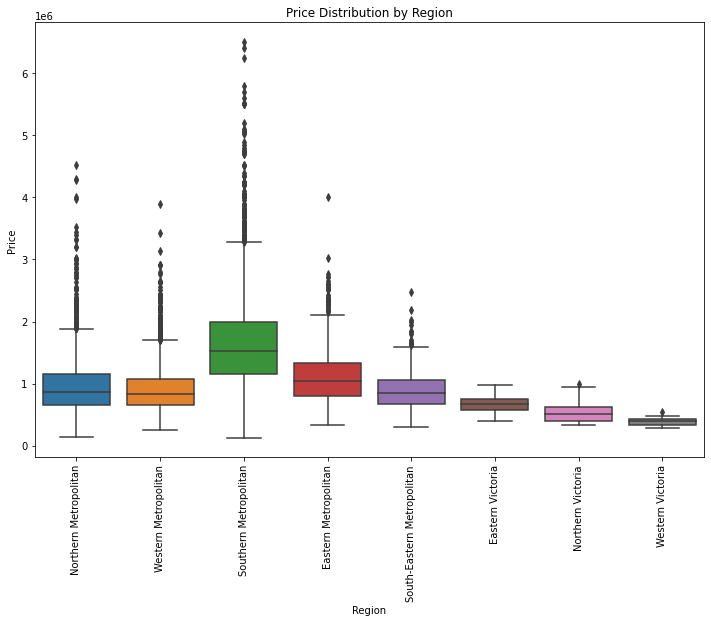

In [22]:

#boxplot and scatter plot show one extreme value in south-eastern metropolitan. i will remove it manually
df7 = df7[~((df7['Regionname'] == 'South-Eastern Metropolitan') & (df7['Price'] > 6000000))]

# it seems right to me. distance for specific region from city look good.
df7.groupby('Regionname')['Distance'].mean().sort_values()

#first i was thinking to remove one of them either regionname or distance.but when i check there relation with price. as distance increase in specific region the price drop. so i will keep both

#scatter plot
py.figure(figsize=(12, 8))
sns.scatterplot(x='Landsize', y='Price', hue='Regionname', data=df7, palette='Set1')
py.title('Price vs Distance for All Regions')
py.xlabel('Landsize')
py.ylabel('Price')
py.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
py.show()
#boxplot
py.figure(figsize=(12, 8))
sns.boxplot(x='Regionname', y='Price', data=df7)
py.title('Price Distribution by Region')
py.xlabel('Region')
py.ylabel('Price')
py.xticks(rotation=90)
py.show()



In [23]:
df_encoded = pd.get_dummies(df7, columns=['Regionname', 'Type'], drop_first=True)
type_encoder = LabelEncoder()
region_encoder = LabelEncoder()
df7['Region_encoded'] = region_encoder.fit_transform(df7['Regionname'])
df7['Type_encoded'] = type_encoder.fit_transform(df7['Type'])

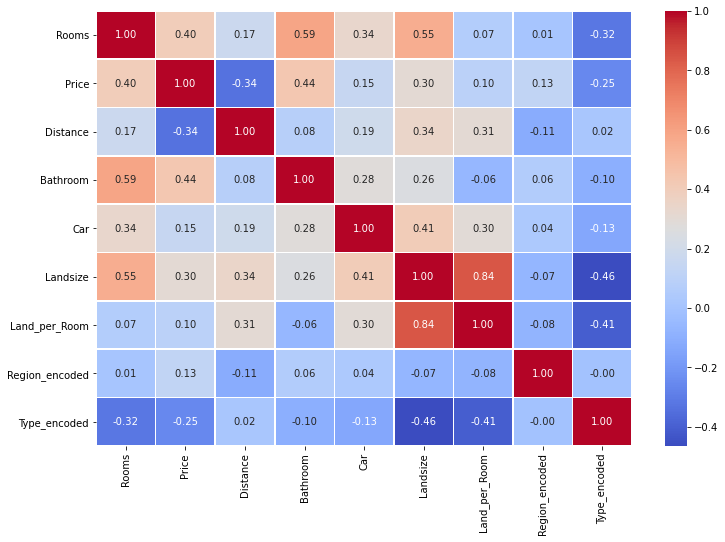

In [24]:

correlation_matrix = df7.corr()
py.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
py.show()

In [25]:
# every house have a bathroom. removing the data in which have no bathroom
df7[df7['Bathroom'] == 0]
df7 = df7[~(df7['Bathroom'] == 0)]
df7['Price_log'] = np.log1p(df7['Price'])


In [26]:
#for data traning removing suburbs. feature importance tool i found later, cars not have signifull impact on the prediction. so i removed it.
df8 = df7.drop(['Suburb', 'Land_per_Room', 'Regionname', 'Type','Price' ,'Car', 'Type_encoded'], axis='columns') 
df8.columns

Index(['Rooms', 'Distance', 'Bathroom', 'Landsize', 'Region_encoded',
       'Price_log'],
      dtype='object')

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

X = df8.drop(columns=['Price_log'])  # All columns except 'Price'
y = df8['Price_log']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=41)
model.fit(X_train, y_train)
model.score(X_test, y_test)


0.797734599484979

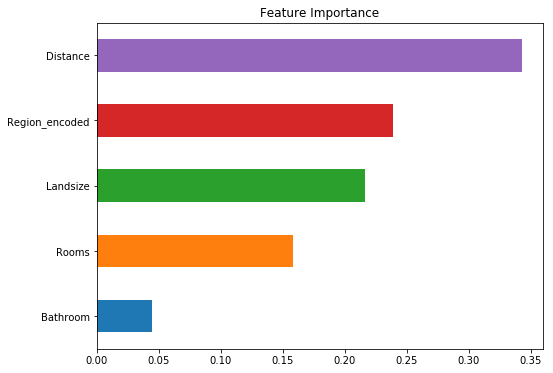

In [1007]:
feature_importances = pd.Series(model.feature_importances_, index=X_train.columns)
feature_importances.sort_values().plot(kind='barh', figsize=(8,6), title="Feature Importance")
py.show()

In [1008]:

# Evaluate using performance metrics
y_pred = model.predict(X_test)

from sklearn.metrics import mean_squared_error, r2_score

# Mean Squared Error (MSE) for regression
mse = mean_squared_error(y_test, y_pred)

# R² score for regression (how well the model fits the data)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R² Score:", r2)

Mean Squared Error: 0.0461596544286511
R² Score: 0.7975487973480972


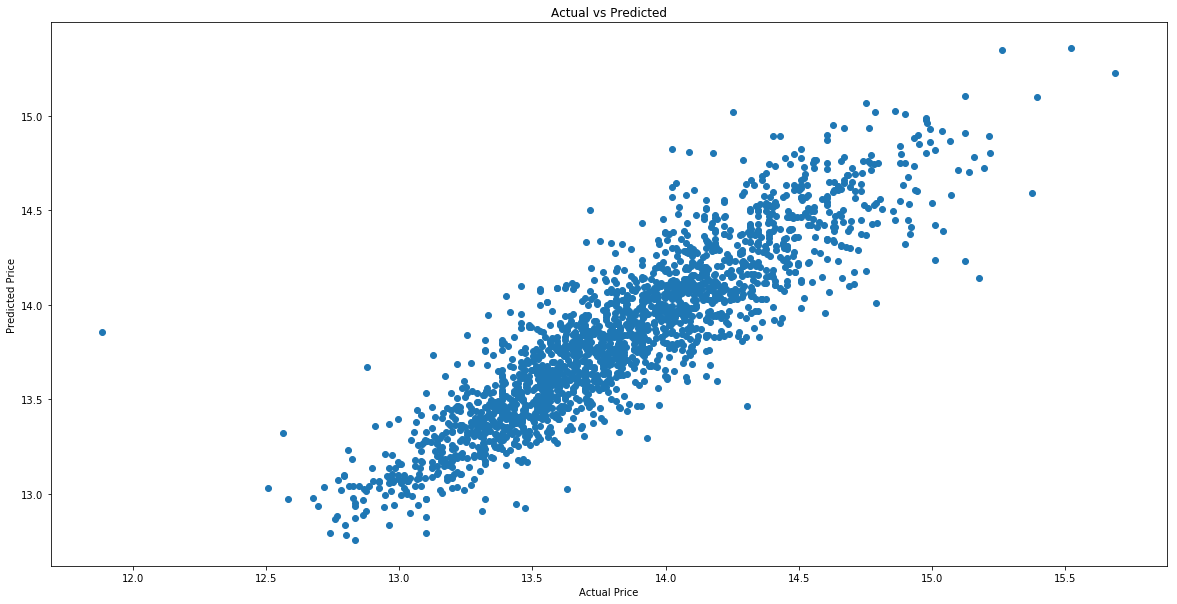

In [1009]:
py.scatter(y_test, y_pred)
py.xlabel("Actual Price")
py.ylabel("Predicted Price")
py.title("Actual vs Predicted")
py.show()

In [979]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(RandomForestRegressor(), param_grid, cv=5)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'min_samples_split': 10, 'n_estimators': 200, 'max_depth': 30}


In [1010]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=200,min_samples_split=10, max_depth=30, random_state=41)
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.8116399690212135

In [1011]:
region_mapping = dict(zip(region_encoder.classes_, range(len(region_encoder.classes_))))

# Save both mappings to JSON
mappings = {
    "Region": region_mapping,
}

with open("label_mappings.json", "w") as f:
    json.dump(mappings, f)

print(region_mapping)

{'Northern Metropolitan': 2, 'South-Eastern Metropolitan': 4, 'Eastern Metropolitan': 0, 'Southern Metropolitan': 5, 'Eastern Victoria': 1, 'Western Metropolitan': 6, 'Northern Victoria': 3, 'Western Victoria': 7}


In [28]:
import joblib

joblib.dump({"model": model, "features": list(X.columns)},'melbourne_house_priceing_model.pkl')

['melbourne_house_priceing_model.pkl']

In [29]:
print(list(X.columns))

['Rooms', 'Distance', 'Bathroom', 'Landsize', 'Region_encoded']


In [1014]:
test_input = np.array([[3, 20, 2, 100, 5]])  # Example test data

# Predict price
predicted_price = model.predict(test_input)[0]
print(np.expm1(predicted_price))

721677.1280227463
